<h1>Wine Review and recommendation</h1>
<h3>Krishna D.B. Anapindi, Individual Project, STAT 542</h3>

**Introduction** <br/>
In this project, I will be performing an indepth analysis of wine-reviews and build a model to predict the review points given to each wine given certains attributes of the wine such as the description of the wine, the price per bottle, region/ country from which the wine has been produced, the winery from which the wine is produced and the taster who reviewd the wine. Since the wine ratings are a continuous distribution, (though not strictly continuous as the ratings only take integer values, for the purpose of this study, we assume them to be continuous) I will build regression models to see whether I can predict the ratings. To begin with, I start with a baseline model i.e. a linear regression to see how well the chosen covariates capture the ratings. further I plan to test two model:
- A **Ridge regression**-which is a simple yet powerful model that performs L2 regularization on the $\beta$ values.
- A more pwerful gradient-boosting algorithm based on decision trees; the **CatBoost** which is designed to handle categorical data. Since the current dataset has a mix of both continuous and categorical data, I have specifically chosen this approach.

Finally, using these approaches, I was able to successfully model the reviews of a wide range of wines.

The second part of the project deals with coming up with recommendation of wineries to a customer based on his/her specific interests in Pinot Noir wines with a fruity flavor and under $20. For this, I make use of a dual-ranking approach. First, I rank all the wineries based on their similarity to the customer's description of a fruity wine. Secondly, I rank all the wineries based on thier ratings (considering only pinot noir). Next I sum up both the ranks and then choose the top 5 wineries that have the best ranking.

 

In [12]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from gensim.scripts.glove2word2vec import glove2word2vec 
from gensim.models import KeyedVectors
import re
import time
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import catboost as ctb
import seaborn as sns

In [13]:
#os.chdir('C:/Users/Krishna/OneDrive/Krishna/Coursework/STAT542/Ind_project/wine-reviews') #desktop
os.chdir('C:/Users/krish/OneDrive/Krishna/Coursework/STAT542/Ind_project/wine-reviews') #laptop

#parsing the input data
inp_data=pd.read_csv('inp_data.csv')


For data processing, initially I remove the duplicate values (based on the review 'description'. Once this is performed, I then remove any null values present. For null values, I only consider the **price**, **description** and **points**.

In [14]:
proc_data=inp_data.drop_duplicates(subset='description', keep="first")
proc_data=proc_data.dropna(subset=['price','description','points'])
proc_data=proc_data.reset_index(drop=True)

Since the description plays a majpr role in deciding the rating of a wine, they have to be incorporated into our model. There are several different ways available to convert texual data into numeric vectors. Here, I will be using the **Global Vectors for Word Representation (GloVe)** algorithm. GloVe is an unsupervised learning algorithm that is used to obtain vector representation of words. The training is performed on a aggregated global word-word co-occurrence statsitcs from the entire Wikipedia 2014 database. I used a constant vector size (100) to represent each word. The vectors from each of the word from a given review are added and normalized to the length of the entire review to ensure that all the vectors have constant variance.

In [117]:
#os.chdir('C:/Users/Krishna/Desktop/ind_project/glove.6B') #desktop
os.chdir('C:/Users/krish/Desktop/ind_proj_542/glove.6B')#laptop
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
word2vec_mod = KeyedVectors.load_word2vec_format(filename, binary=False)

In [16]:

#function to converd words to vectors
def word2vec(X,model):
    result_array=[]
    t1=time.time()
    if len(X)>0
    for i in range(1,len(X)):
            x_strip=re.sub(r'[^\w\s]','',X[i]) #strip the punctuation
            list_token=x_strip.split()
            token_vec=np.zeros(100)

            for j in range(1,len(list_token)):
                if list_token[j] in model.vocab:
                    token_vec=token_vec+model.get_vector(list_token[j])
                else:
                    token_vec=token_vec
            token_vec=(token_vec.reshape(-1,1))/len(list_token)
            token_vec=token_vec.squeeze()
            result_array.append(token_vec)

    result_df=pd.DataFrame(result_array) 
    t2=time.time()
    return(result_df)
  

In [17]:
X=proc_data['description']
word2vec_df=word2vec(X,model)

In [18]:
col_names=['desc'+str(id) for id in range(0,100)]
word2vec_df.columns=col_names

**Descriptive Statistics** <br/>

As for the exploratory data analysis, the first step would be to identify the underlying distribution of our dependent variable (points).

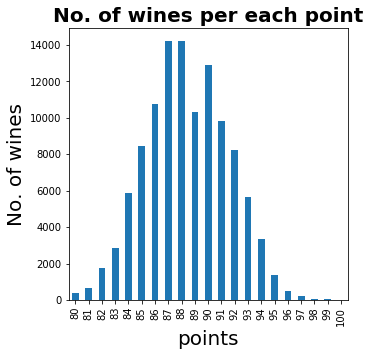

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_title('No. of wines per each point', fontweight="bold", size=20) 
ax.set_ylabel('No. of wines', fontsize = 20)
ax.set_xlabel('Points', fontsize = 20)
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10) 
proc_data.groupby(['points']).count()['description'].plot(ax=ax, kind='bar')

This distribution suggests that the points foloow an approximate normal distribution. Secondly, price usually has a strong influence onthe quality of the wine. So will plot the wine points vs. price to see if there is a strong correlation.

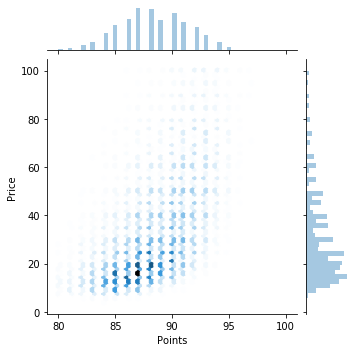

In [23]:
#since most wines are below $100, I filtered out the really expensive ones so that the points and price can be compared easily

df_price_filt=proc_data.loc[proc_data['price']<=100]


g=(sns.jointplot(x='points',y='price', height=5,data=df_price_filt, kind="hex")).set_axis_labels("Points", "Price")


From this plot, one can infer that there is a weak positive correlation between the points and the price. Hence including the price in our model would be good idea.

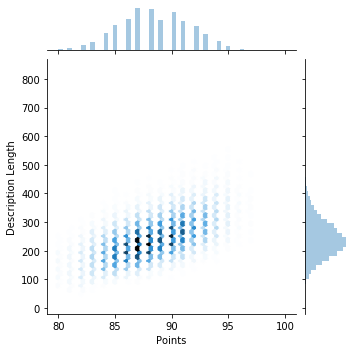

In [24]:
df_desc_len=proc_data.assign(desc_len=proc_data['description'].apply(len))
g=(sns.jointplot(x='points',y='desc_len', height=5,data=df_desc_len, kind="hex")).set_axis_labels("Points", "Description Length")

From the above plot, it seems like there is a very strong positive correlation between the length of the review and the points. Hence this could be used as an engineered feature to predict the points.

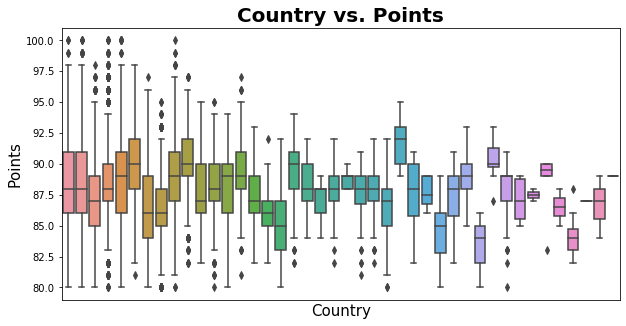

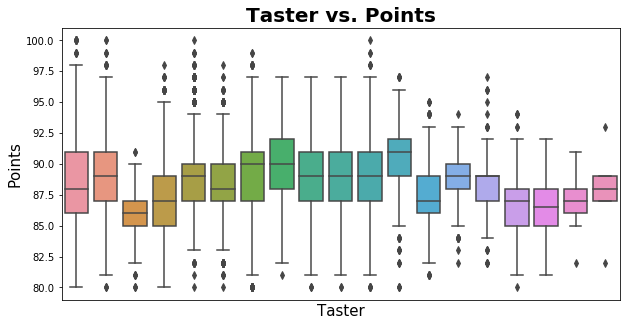

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='country', y='points', data=df_desc_len)
plt.xticks([])
plt.yticks(fontsize=10) 
ax.set_title('Country vs. Points', fontweight="bold", size=20) 
ax.set_ylabel('Points', fontsize = 15) 
ax.set_xlabel('Country', fontsize = 15) 
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='taster_name', y='points', data=df_desc_len)
plt.xticks([])
plt.yticks(fontsize=10) 
ax.set_title('Taster vs. Points', fontweight="bold", size=20) 
ax.set_ylabel('Points', fontsize = 15) 
ax.set_xlabel('Taster', fontsize = 15) 
plt.show()

From the above two box plots, it seems that the country of origin and the taster who actually reviewd the wine do exhibit a significant variation. However, there is no obvious pattern and it will be interesting to see if the final model actually picks up any of these covariates.<br/> Since the taster's name and twitter handle essentially capture the same information, I am not including either of them. Lastly, I will be excluding region1, region2 and title for now. All these covariates have either too many NULL values or do not really contribute towards the points. Winery is another feature that could potentially be used, but since there are too many unique values for the winery category, I will be ignoring that too for now.

In [33]:
proc_data_red=df_desc_len.drop(['designation', 'description',  'province',
       'region_1', 'region_2', 'taster_twitter_handle', 'title',
        'winery'], axis=1)

The final step of dataprocessing is one-hot encoding. This is such that the model can handle categorical data.

In [34]:
features = pd.get_dummies(proc_data_red)

The next step is to concatenate the one hot encoded predictors with the word2vec predictors.

In [41]:
final_feat=pd.concat([features,word2vec_df], axis=1)
final_feat=final_feat.fillna(0)
final_feat.head()
y=final_feat['points']
X_feat=final_feat.drop(columns=['points']) 

In [42]:

X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.1, random_state=1)


In [37]:
#defining a function to calculate adjusted R2 and RMSE

def reg_metrics(y_pred,y_test,p):
    SSRes=sum((y_test-y_pred)**2)
    SSTot=sum((y_test-np.mean(y_pred))**2)
    
    R_sq=1-(float(SSRes))/SSTot
    adj_R_sq= 1-(1-R_sq)*(len(y_test)-1)/(len(y_test)-p-1)
    rmse=(sum((np.array(y_test).astype(float)-y_pred)**2)/(len(y_test)))**0.5
    
    return R_sq, adj_R_sq, rmse

In [44]:
model=LinearRegression()
model.fit(X_train,y_train)
p=X_test.shape[1]
y_pred=model.predict(X_test)

lin_reg_met=reg_metrics(y_pred,y_test,p)


In [45]:
print('Metrics for the linear model-R^2:',lin_reg_met[0],', Adj_R^2:',lin_reg_met[1],', RMSE',lin_reg_met[2])

Metrics for the linear model-R^2: 0.5858696090359901 , Adj_R^2: 0.5512782982134329 , RMSE 1.9922263418444983


Based on the above metrics, the model is able to capture the varaibility in the data to some extent. However, from the reletively low adjusted R2 value, we can conclude that there is definitely more scope for improvement. This linear regression case will be considered as a base-line performance for further analysis.  

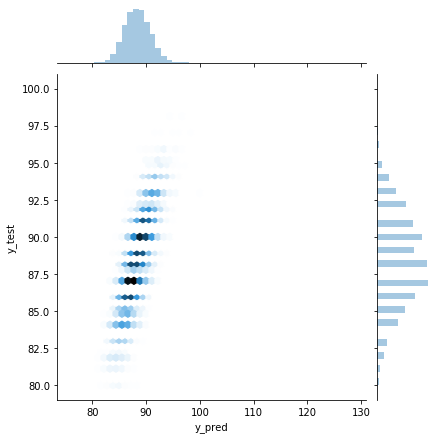

In [46]:
g=(sns.jointplot(y_pred,y_test, kind="hex")).set_axis_labels("y_pred", "y_test")

In [47]:
#Ridge regression with different alpha values and cross validation
X_feat=final_feat.drop(columns=['points'])
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.1, random_state=1)

alphas=np.array([0,0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000])

#defining a custom scoring function to use RMSE 
def mean_squared_error_(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5
RMSE = make_scorer(mean_squared_error_, greater_is_better=False) 

model=Ridge()

grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), scoring=RMSE, cv=5)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([0.e+00, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_squared_error_, greater_is_better=False),
             verbose=0)

In [48]:
print(grid.best_score_)
print(grid.best_estimator_.alpha)

-1.9424053722230548
10.0


In [49]:
model=Ridge(alpha=10)
model.fit(X_train,y_train)
p=X_test.shape[1]
y_pred=model.predict(X_test)
ridg_reg_met=reg_metrics(y_pred,y_test,p)

In [50]:
print('Metrics for the Ridge model-R^2:',ridg_reg_met[0],', Adj_R^2:',ridg_reg_met[1],', RMSE',ridg_reg_met[2])

Metrics for the Ridge model-R^2: 0.5856088452098107 , Adj_R^2: 0.5509957534149814 , RMSE 1.9928534520878802


As we can see from the above metrics, ridge model has almost the same performance as compared to the linear regression. Finding the co-effecients that have the largest weights:

In [70]:
coef=pd.Series(model.coef_, index=X_train.columns)
imp_coef=coef.sort_values(ascending=False)

Text(0.5, 1.0, 'Feature importance (+ve) using Lasso Model')

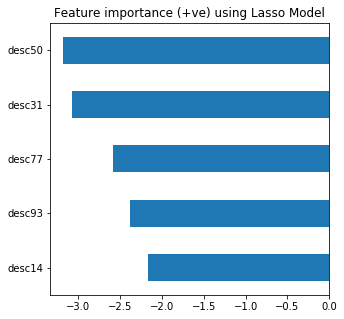

In [71]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5, 5)
imp_coef[-5:].plot(kind = "barh")
plt.title("Feature importance (+ve) using Lasso Model")

Text(0.5, 1.0, 'Feature importance (-ve) using Lasso Model')

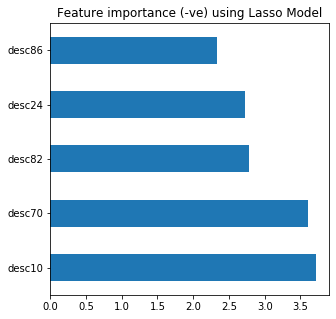

In [72]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5, 5)
imp_coef[:5].plot(kind = "barh")
plt.title("Feature importance (-ve) using Lasso Model")

In [107]:
model = Ridge(alpha=0)
model.fit(X_train, y_train)
ridge_df = pd.DataFrame({'variable':X_train.columns, 'estimate': model.coef_})
ridge_train_pred = []
ridge_test_pred = []
alphas=np.array([0,0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000])

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    var_name = str(alpha)
    ridge_df[var_name] = model.coef_

    ridge_train_pred.append(model.predict(X_train))
    ridge_test_pred.append(model.predict(X_test))

ridge_df = ridge_df.set_index('variable').T.rename_axis('estimate').rename_axis(None).reset_index()
ridge_df=ridge_df.iloc[1:]
ridge_df.set_index('index', inplace=True)

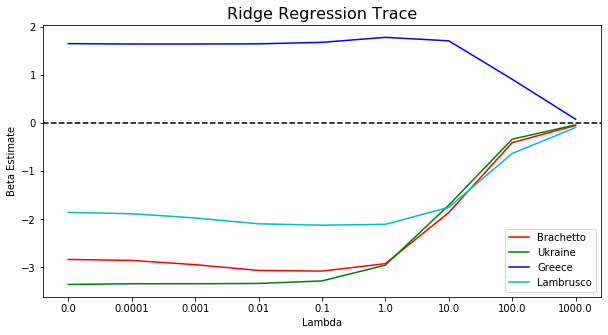

In [103]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ridge_df.variety_Brachetto, 'r', ridge_df.country_Ukraine , 'g', ridge_df.country_Greece, 'b', 
        ridge_df.variety_Lambrusco ,'c')
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Lambda")
ax.set_ylabel("Beta Estimate")
ax.set_title("Ridge Regression Trace", fontsize=16)
ax.legend(labels=['Brachetto','Ukraine','Greece','Lambrusco'])


Though the vectors corresponding to the description contributed the most towards predicting the wine review, there were a few other covariates that did matter. For example the countries Greece/ Ukriane and the variety Brachetto and Lambrusco did rank significantly high in their coeffecient values. From the above Ridge trace, one can infer that the country Greece had a positive influence on the wine rating while the country Ukraine and the varieties Brachetto and Lambrusco had a negative influence on the wine points. Moreover, the trace of Greece went to zero later than the other traces which shows that it has higher contribution towards the overall points of the wine.
<br/>

**Model 2**<br/>

CatBoost

In [74]:
model=ctb.CatBoostRegressor(verbose=False)

parameters = {'depth'         : [3,5],
                  'learning_rate' : [0.1],
                  'iterations'    : [100,200,500]
                 }

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs=-1, scoring=RMSE)

grid.fit(X_train,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x000001A75358AFD0>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [3, 5], 'iterations': [100, 200, 500],
                         'learning_rate': [0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_squared_error_, greater_is_better=False),
             verbose=0)

In [75]:
print(grid.best_score_)
print(grid.best_params_)

-1.7317867358079
{'depth': 5, 'iterations': 500, 'learning_rate': 0.1}


In [76]:
model=ctb.CatBoostRegressor(depth=5, iterations=500, learning_rate=0.1, verbose=False)

model.fit(X_train,y_train)

In [77]:
cat_coeff_imp=model.get_feature_importance(type="PredictionValuesChange")

In [78]:
len(cat_coeff_imp)

top_10_idx_cat = np.argsort(cat_coeff_imp)[-10:]

final_feat.columns[top_10_idx_cat]

Index(['taster_name_Roger Voss', 'desc13', 'taster_name_Anna Lee C. Iijima',
       'country_Turkey', 'desc42', 'taster_name_Paul Gregutt', 'desc69',
       'taster_name_Matt Kettmann', 'price', 'points'],
      dtype='object')

In [87]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

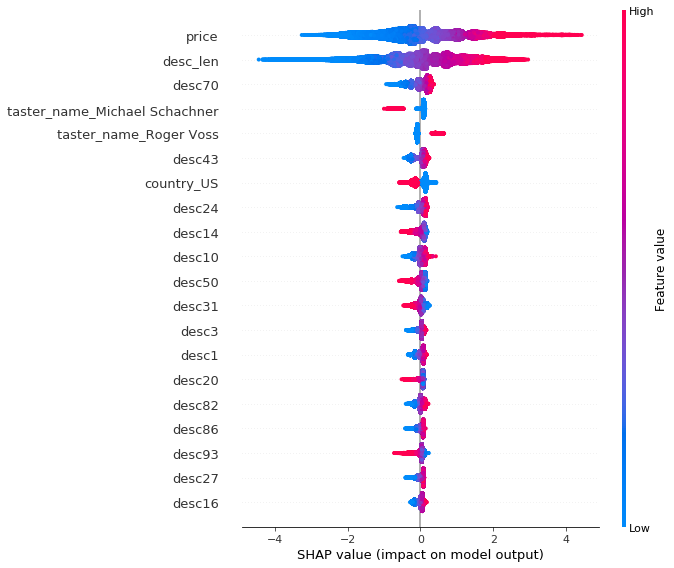

In [95]:
shap.summary_plot(shap_values, X_train)

In [98]:
_,_,rmse_cat=reg_metrics(y_pred,y_test,p)

In [100]:
print('Metrics for the CatBoost model-RMSE:',rmse_cat)

Metrics for the CatBoost model-RMSE: 1.7385555489823439


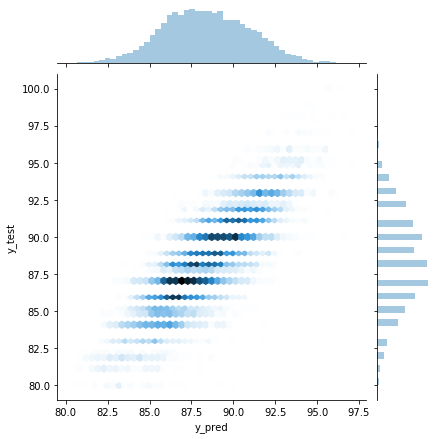

In [104]:
import matplotlib.pyplot as plt

g=(sns.jointplot(y_pred,y_test, kind="hex")).set_axis_labels("y_pred", "y_test")


<h2> Part2 </h2>
<br\>
To capture more information about the wine, I am going to assume that the following description for a fruity Pinot Noir wine-"A medium-bodied Pinot Noir with fresh red fruit flavors of cherries, strawberries, blackberries and rasberry".

Using this sentence, I then generate a vector from the GloVe algorithm (described previously). Then, I find the closes point to this description from the input dataset (pre-processed to remove wines that are not pinor noir and above $20). Using a dissimilarity matrix constructed based on **Gower Distance** (which can handle mixed type of data containing both categorical and continuous predictors), I then rank the wines based on their similarity to the given description. 

Simultaneously, I also rank all the wines based on their points and average the points for each of the winery. Finally, I combined these two rankings (after normalization) and then choose the top five. Using this approach, I not only account for the best wine rating points, but other features such as the country of origin, the review given by the taster, price and variety (all these are accounted for while calculating the Gower Distance) hence giving an overall best recommendation.


In [108]:
#This code for gower distance is adapted from an existing GitHub repository and was not coded by me
from sklearn.neighbors import DistanceMetric

epsilon = 10**(-8)
def gower_distance(X):
    """
    This function expects a pandas dataframe as input
    The data frame is to contain the features along the columns. Based on these features a
    distance matrix will be returned which will contain the pairwise gower distance between the rows
    All variables of object type will be treated as nominal variables and the others will be treated as 
    numeric variables.
    Distance metrics used for:
    Nominal variables: Dice distance (https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
    Numeric variables: Manhattan distance normalized by the range of the variable (https://en.wikipedia.org/wiki/Taxicab_geometry)
    """
    individual_variable_distances = []

    for i in range(X.shape[1]):
        feature = X.iloc[:,[i]]
        if feature.dtypes[0] == np.object:
            feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature))
        else:
            feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) /max(np.ptp(feature.values), epsilon)
            
        individual_variable_distances.append(feature_dist)

    return np.array(individual_variable_distances).mean(0)

In [168]:
proc_data_q2=pd.concat([proc_data,word2vec_df], axis=1)

**Data Preprocessing**

Similar to the previous solution, I've eliminated the fields such as designation, province, region, taster_twitter_hande and title. I've also filtered the dataset so that our recommendation engine only looks for Pinot Noir under $20.

In [169]:
proc_data_q2=proc_data_q2.drop(['designation', 'description',  'province',
       'region_1', 'region_2', 'taster_twitter_handle', 'title'], axis=1)

df_pinot=proc_data_q2.loc[proc_data_q2['variety'] == 'Pinot Noir']
df_pinot_price=df_pinot.loc[df_pinot['price']<=20].dropna()
df_pinot_price=df_pinot_price.reset_index(drop=True)
df_pinot_price=df_pinot_price.drop(columns=['variety'])

The next step is to calculate the dissimilarity matrix base don gower distance. And then choose the wines that are closest to the given description.

In [170]:
gr_dist=gower_distance(df_pinot_price)

In [171]:
gr_dist.shape


(1326, 1326)

Next, we'll find the word2vec representation of our customer's decription of the wine he/she is interested in.

In [172]:
cust_desc=str('A medium-bodied Pinot Noir with fresh red fruit flavors of cherries, strawberries, blackberries and rasberry')

x_strip=re.sub(r'[^\w\s]','',cust_desc) #strip the punctuation so that every word can fit into 
    
list_token=x_strip.split()
token_vec=np.zeros(100)

for j in range(1,len(list_token)):   
    if list_token[j] in word2vec_mod.vocab:   
        token_vec=token_vec+word2vec_mod.get_vector(list_token[j])      
    else:   
        token_vec=token_vec   
token_vec=(token_vec.reshape(-1,1))/len(list_token)  
token_vec_cust=token_vec.squeeze()

In [173]:
from sklearn.metrics.pairwise import cosine_similarity
dist_pinot=df_pinot_price.loc[:,'desc0':'desc99']

cos_sim=cosine_similarity(dist_pinot, token_vec_cust.reshape(1,-1))

In [174]:
max_ind=np.argmax(cos_sim)

In [175]:
max_ind

753

In [176]:
gr_dist_maxind=gr_dist[max_ind,]

In [153]:
min(gr_dist_maxind)

0.0

This dataframe below has the list of all wines arranged in descending order based on the distnace similarity. That is the best matching wines are ranked high and the worst matching wines are ranked lower

In [177]:
df_sort_pinot_price=df_pinot_price.iloc[np.argsort(gr_dist_maxind)]

In [178]:
df_sort_pinot_price=df_sort_pinot_price.reset_index()

In [179]:
df_sort_pinot_price['rank']=df_sort_pinot_price.index

In [181]:
df_pp_grp=df_sort_pinot_price.groupby(['winery']).count()

In [184]:
df_pp_grp

,index,country,points,price,taster_name,desc0,desc1,desc2,desc3,desc4,...,desc91,desc92,desc93,desc94,desc95,desc96,desc97,desc98,desc99,rank
winery,,,,,,,,,,,,,,,,,,,,,
10Span,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
42°S,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
A Blooming Hill Vineyard,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
A to Z,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
Acrobat,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
Acumen,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Ad Lib,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Agustinos,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Aila,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
